Imports

In [1]:
import os
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import sampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Load Data

In [14]:
diff_grid = np.load('dataset/diff_grid_data.npz')['arr_0']
label = np.load('dataset/diffraction_label.npz')['arr_0']

Model

Encoder

In [16]:
def conv(in_channels, out_channels):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.BatchNorm2d(out_channels),
  )
  
def conv_max(in_channels, out_channels):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=3, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.BatchNorm2d(out_channels),
  )

In [17]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = conv(1, 16)
    self.block2 = conv_max(16, 32)
    self.block3 = conv_max(32, 64)
    self.block4 = conv_max(64, 128)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

Decoder

In [18]:
def convTrans(in_channels, out_channels):
  return nn.Sequential(
    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=2),
    #nn.ReLU(inplace = True),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
  )

def up_conv(in_channels, out_channels, padding):
  return nn.Sequential(
    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=5, stride=2, padding=padding),
    #nn.ReLU(inplace = True),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.BatchNorm2d(out_channels),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
  )

In [19]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = up_conv(128, 64, 1)
    self.block2 = convTrans(64, 32)
    self.block3 = up_conv(32, 16, 2)
    self.block4 = convTrans(16, 1)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

Encoder-Decoder Model

In [20]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.encoder = Encoder()
    self.phase_decoder = Decoder()
    self.amp_decoder = Decoder()
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self, diffraction):
    latent_z = self.encoder(diffraction)
    phase = self.tanh(self.phase_decoder(latent_z))
    phase = phase*cp.pi
    amp = self.sigmoid(self.amp_decoder(latent_z))
    return phase, amp

Training

In [21]:
lossfn =  nn.MSELoss()
def ModelLoss(preds1, targets1, preds2, targets2):
  loss1 = lossfn(preds1, targets1)
  loss2 = lossfn(preds2, targets2)
  # loss2 = nn.functional.binary_cross_entropy(preds2, targets2, reduction='mean')
  return loss1, loss2

In [22]:
PtychoModel = Model().to(device)
# PtychoModel.load_state_dict(torch.load('overfit.pth'))
diff = torch.tensor(diff_grid,device=device).float()
phase = torch.tensor(label[:, 0],device=device).float()
amp = torch.tensor(label[:, 1],device=device).float()

In [41]:
num_epochs = 1000
# Look into Scheduler: (varies the learning rate of optimizer) scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=, max_lr=, step_size_up=)
optimizer = torch.optim.Adam(PtychoModel.parameters(), lr=0.000018, betas=(0.75, 0.999))
for epoch in range(num_epochs):

  PtychoModel.train()
  phase_pred, amp_pred = PtychoModel(diff)
  loss1, loss2 = ModelLoss(phase_pred, phase, amp_pred, amp)
  loss = loss1+loss2

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  print("Epoch: ", (epoch+1), "Training Loss: ", round(loss.item(), 5), round(loss1.item(), 7), round(loss2.item(), 7))

Epoch:  1 Training Loss:  0.09496 0.0946291 0.000333
Epoch:  2 Training Loss:  0.09499 0.0946587 0.0003333
Epoch:  3 Training Loss:  0.09498 0.0946468 0.0003331
Epoch:  4 Training Loss:  0.09498 0.0946498 0.0003331
Epoch:  5 Training Loss:  0.09498 0.0946496 0.0003331
Epoch:  6 Training Loss:  0.09498 0.0946495 0.0003331
Epoch:  7 Training Loss:  0.09498 0.0946477 0.0003331
Epoch:  8 Training Loss:  0.09498 0.0946468 0.000333
Epoch:  9 Training Loss:  0.09498 0.0946455 0.000333
Epoch:  10 Training Loss:  0.09498 0.0946453 0.000333
Epoch:  11 Training Loss:  0.09498 0.0946424 0.000333
Epoch:  12 Training Loss:  0.09497 0.0946412 0.000333
Epoch:  13 Training Loss:  0.09497 0.0946391 0.000333
Epoch:  14 Training Loss:  0.09497 0.0946369 0.000333
Epoch:  15 Training Loss:  0.09497 0.0946352 0.000333
Epoch:  16 Training Loss:  0.09497 0.0946341 0.000333
Epoch:  17 Training Loss:  0.09497 0.0946323 0.000333
Epoch:  18 Training Loss:  0.09496 0.0946309 0.000333
Epoch:  19 Training Loss:  0.09

In [42]:
PtychoModel.eval()
phase_pred, amp_pred = PtychoModel(diff)

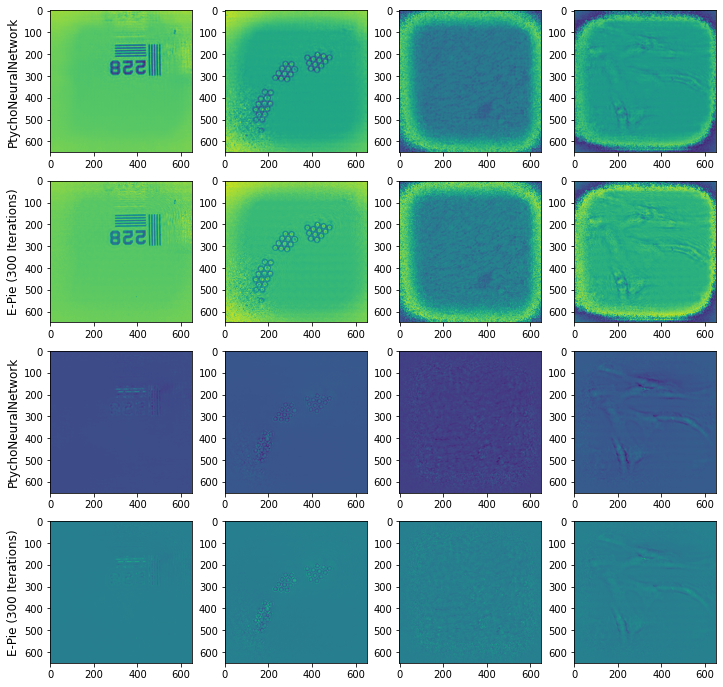

In [52]:
f, ax = plt.subplots(4,4, figsize=(12, 12))
ax[0,0].set_ylabel('PtychoNeuralNetwork', fontsize = 12.0)
ax[1,0].set_ylabel('E-Pie (300 Iterations)', fontsize = 12.0)
ax[2,0].set_ylabel('PtychoNeuralNetwork', fontsize = 12.0)
ax[3,0].set_ylabel('E-Pie (300 Iterations)', fontsize = 12.0)

ax[0,0].imshow(phase_pred[0].cpu().detach().numpy().reshape((650,650)))
ax[0,1].imshow(phase_pred[1].cpu().detach().numpy().reshape((650,650)))
ax[0,2].imshow(phase_pred[2].cpu().detach().numpy().reshape((650,650)))
ax[0,3].imshow(phase_pred[3].cpu().detach().numpy().reshape((650,650)))
ax[1,0].imshow(phase[0].cpu().detach().numpy().reshape((650,650)))
ax[1,1].imshow(phase[1].cpu().detach().numpy().reshape((650,650)))
ax[1,2].imshow(phase[2].cpu().detach().numpy().reshape((650,650)))
ax[1,3].imshow(phase[3].cpu().detach().numpy().reshape((650,650)))
ax[2,0].imshow(amp_pred[0].cpu().detach().numpy().reshape((650,650)))
ax[2,1].imshow(amp_pred[1].cpu().detach().numpy().reshape((650,650)))
ax[2,2].imshow(amp_pred[2].cpu().detach().numpy().reshape((650,650)))
ax[2,3].imshow(amp_pred[3].cpu().detach().numpy().reshape((650,650)))
ax[3,0].imshow(amp[0].cpu().detach().numpy().reshape((650,650)))
ax[3,1].imshow(amp[1].cpu().detach().numpy().reshape((650,650)))
ax[3,2].imshow(amp[2].cpu().detach().numpy().reshape((650,650)))
ax[3,3].imshow(amp[3].cpu().detach().numpy().reshape((650,650)))

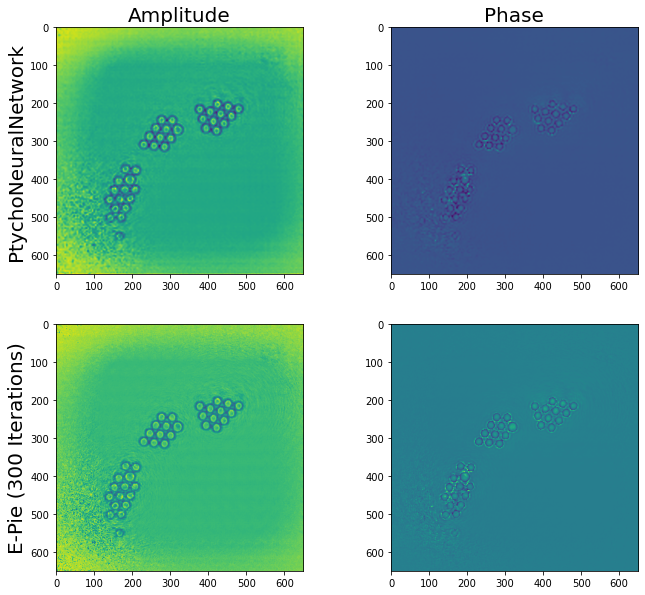

In [13]:
f, ax = plt.subplots(2,2, figsize=(11, 10))
ax[0,0].set_ylabel('PtychoNeuralNetwork', fontsize = 20.0)
ax[0,0].set_title('Amplitude', fontsize = 20.0)
ax[0,0].imshow(phase_pred[0].cpu().detach().numpy().reshape((650,650)))
ax[0,1].set_title('Phase', fontsize = 20.0)
ax[0,1].imshow(amp_pred[0].cpu().detach().numpy().reshape((650,650)))
ax[1,0].set_ylabel('E-Pie (300 Iterations)', fontsize = 20.0)
ax[1,0].imshow(phase[0].cpu().detach().numpy().reshape((650,650)))
ax[1,1].imshow(amp[0].cpu().detach().numpy().reshape((650,650)))

In [53]:
torch.save(PtychoModel.state_dict(), 'overfit4.pth')